<a href="https://colab.research.google.com/github/Talizg03/weather/blob/main/project_2__Tali_28_1_25ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

df = pd.read_csv("Train.csv")
#print(df.head())
df.head()

Saving Train.csv to Train.csv


<ipython-input-7-1280e8b6c072>:5: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Train.csv")


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

In [8]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
X, y = df.drop(columns='SalePrice'), df['SalePrice']
feature_names = X.columns

def train_model(X, y):
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].astype('category')

        if X[col].dtype == 'category':
            X[col] = X[col].cat.codes

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest model
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Evaluate model performance using RMSE
    from sklearn.metrics import mean_squared_error
    y_pred = rf.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    y_train_pred = rf.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred) ** 0.5
    print("RMSE Baseline accuracy:", y_test.std())
    print(f"Train: Root Mean Squared Error (RMSE): {train_rmse}")
    print(f"Test: Root Mean Squared Error (RMSE): {rmse}")
    return rf, (X_train, X_test, y_train, y_test)

rf, xs = train_model(X, y)

RMSE Baseline accuracy: 22865.2041940006
Train: Root Mean Squared Error (RMSE): 3477.5517734221876
Test: Root Mean Squared Error (RMSE): 9255.84222794346


In [9]:
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def perm_importance_df(rf, xs, n_repeats=5, random_state=42):
    """
    Computes permutation importance for a trained model and outputs feature importance.

    Parameters:
    - rf: Trained Random Forest (or similar model).
    - xs: Tuple containing (X_train, X_test, y_train, y_test).
    - n_repeats: Number of times the feature is randomly shuffled (default is 5).
    - random_state: Random seed for reproducibility (default is 42).

    Returns:
    - importance_df: A DataFrame containing feature names, permutation importance,
                      model importance, and their respective ranks.
    """

    # Unpack the input tuple
    X_train, X_test, y_train, y_test = xs

    # Compute Permutation Importance
    perm_importance = permutation_importance(
        rf, X_test, y_test, n_repeats=n_repeats, random_state=random_state, n_jobs=-1
    )

    # Create the results DataFrame
    importance_df = pd.DataFrame({
        "Feature": rf.feature_names_in_,
        "Permutation Importance": perm_importance.importances_mean,
        "Permutation Std Deviation": perm_importance.importances_std,
        "Model Importance": rf.feature_importances_,
    })

    # Add feature type to the DataFrame (Optional)
    importance_df["Feature Type"] = [X_train[col].dtype for col in rf.feature_names_in_]

    # Sort by Permutation Importance and assign ranks
    importance_df = importance_df.sort_values(by="Permutation Importance", ascending=False).reset_index(drop=True)
    importance_df["Permutation Rank"] = importance_df.index + 1
    importance_df["Model Rank"] = importance_df["Model Importance"].rank(ascending=False)

    # Plotting the feature importance comparison
    importance_df.sort_values(by="Permutation Importance", ascending=False).plot(
        x="Feature",
        y=["Permutation Importance", "Model Importance"],
        kind="barh",
        figsize=(10, 6),
        title="Feature Importance Comparison"
    )
    plt.show()

    # Display the DataFrame
    display(importance_df)

    return importance_df

# Example usage
importance_df = perm_importance_df(rf, xs)

PicklingError: Could not pickle the task to send it to the workers.

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd



# Assuming y is your target variable and X are your features
# Log transform the target variable (make sure y has positive values)
y_ = np.log(y)  # apply logarithmic transformation to target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, random_state=42)

# Train the model (assuming you already have a model, like RandomForestRegressor)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions_log = model.predict(X_test)

# If you want to get predictions on the original scale, use the inverse of the log (exponentiation)
predictions_original_scale = np.exp(predictions_log)

# Example: Predicting on a specific test instance (e.g., the first test sample)
example_prediction_log = model.predict(X_test.iloc[[0]])  # Prediction in log scale
example_prediction_original = np.exp(example_prediction_log)  # Convert back to original scale

print("Log-transformed prediction:", example_prediction_log)
print("Original scale prediction:", example_prediction_original)


Log-transformed prediction: [9.99468379]
Original scale prediction: [21909.67919697]


# New Section

# Explanation of the Code:
Log Transformation:

We transform the target variable (y) using np.log(y) to compress the scale of the data. This helps in modeling prices which can have a wide range (like thousands to millions). After predictions, we apply np.exp to convert the log-transformed values back to the original price scale. Data Scaling:

We use StandardScaler to scale the features. This helps the model perform better, especially when features have different scales. Modeling:

We use a RandomForestRegressor, a powerful ensemble model that works well with tabular data. We then evaluate the model using Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). These metrics will help you understand how well the model is performing. Visualization:

The first plot shows the Actual vs Predicted Price on the original scale, allowing us to see how close the predictions are to the actual values. The red line represents the ideal line where predicted values equal actual values. The second plot is a Residual Plot showing the difference between actual and predicted values. This helps in checking if the model is biased or has any systematic errors. Cross-validation:

Optionally, we apply cross-validation to get a better estimate of the model's performance by evaluating it on different train-test splits.

Mean Absolute Error: 5831.7332250379795
Mean Squared Error: 88823907.90515411
Root Mean Squared Error: 9424.64364870917


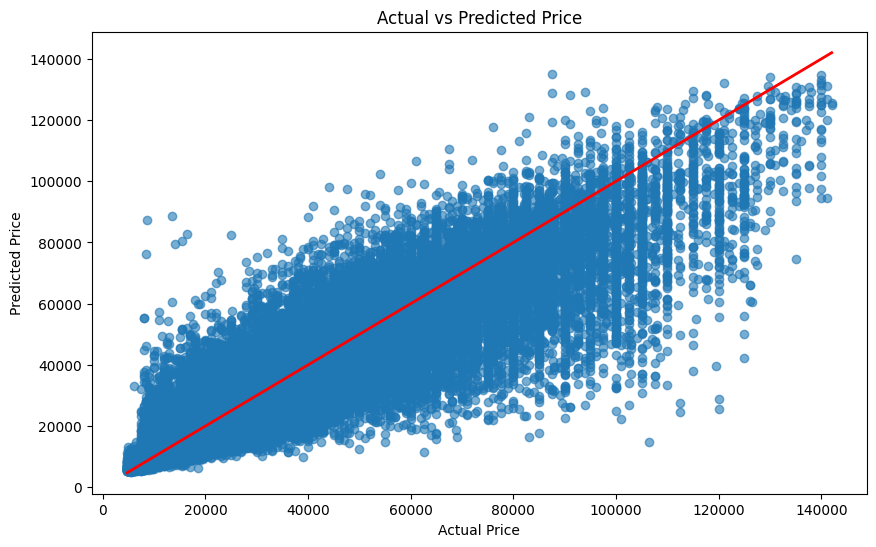

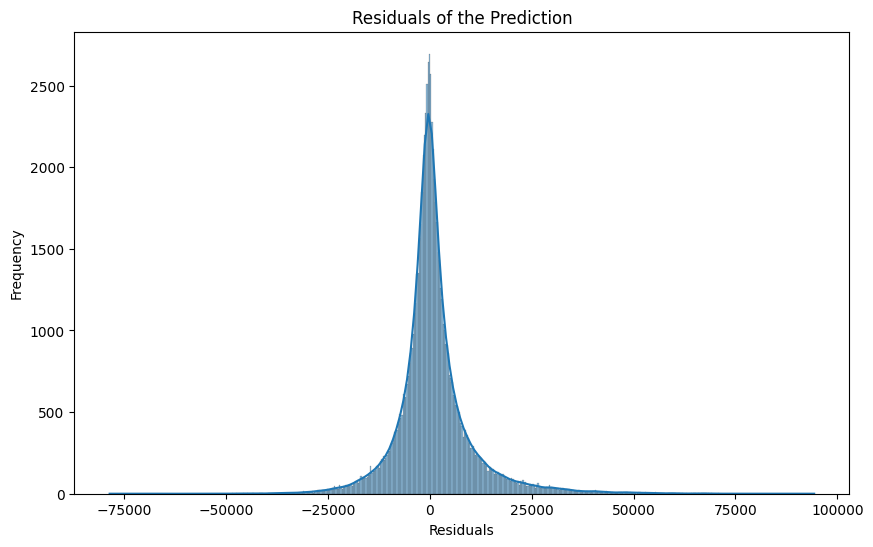

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

# Log-transform the target variable
y_ = np.log(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, random_state=42)

# Scale features if needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_log = model.predict(X_test_scaled)

# Convert the log predictions back to the original scale
y_pred = np.exp(y_pred_log)

# Evaluate model performance
mae = mean_absolute_error(np.exp(y_test), y_pred)
mse = mean_squared_error(np.exp(y_test), y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(np.exp(y_test), y_pred, alpha=0.6)
plt.plot([min(np.exp(y_test)), max(np.exp(y_test))], [min(np.exp(y_test)), max(np.exp(y_test))], color='red', lw=2)
plt.title("Actual vs Predicted Price")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

# Plot residuals
residuals = np.exp(y_test) - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Residuals of the Prediction")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Optionally, you can apply cross-validation
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation Mean Squared Error: {-cross_val_scores.mean()}")

